In [1]:
import pandas as pd
import numpy as np
from sklearnex import patch_sklearn
patch_sklearn()

import sys
import os
import shap

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [2]:
# Setting path to load util functions
from pathlib import Path
parent_dir = Path.cwd().parents[1]
sys.path.append(os.path.abspath(parent_dir))

In [3]:
train_df = pd.read_parquet('../../data/final_features_ml/train_all_features_last_month.parquet')
val_df = pd.read_parquet('../../data/final_features_ml/val_all_features_last_month.parquet')
test_df = pd.read_parquet('../../data/final_features_ml/test_all_features_last_month.parquet')

In [4]:
y_train = pd.read_parquet('../../data/3d_array/train_targets.parquet')
y_val = pd.read_parquet('../../data/3d_array/val_targets.parquet')
y_test = pd.read_parquet('../../data/3d_array/test_targets.parquet')

In [5]:
train_df.sort_values(by = ['customer_ID'], inplace=True)
y_train.sort_values(by = ['customer_ID'], inplace=True)
val_df.sort_values(by = ['customer_ID'], inplace=True)
y_val.sort_values(by = ['customer_ID'], inplace=True)
test_df.sort_values(by = ['customer_ID'], inplace=True)
y_test.sort_values(by = ['customer_ID'], inplace=True)

In [6]:
train_df.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
val_df.reset_index(drop=True, inplace=True)
y_val.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

In [7]:
import pickle
model = pickle.load(open('../../models/machine_learning/eec_xgb_tuned.pkl', 'rb'))

In [8]:
from utils.threshold import find_threshold_binary_search
threshold, _ = find_threshold_binary_search(y_true=y_val['target'].values, y_pred_proba = model.predict_proba(val_df.drop(columns=['customer_ID']))[:, 1])
print(f"Threshold: {threshold}")

Target Recall: >= 0.9800 for Class 0
Threshold found by Binary Search: 0.9026793
Achieved Recall at Threshold: 0.9800
Threshold: 0.9026793241500854


In [9]:
#get predictions for test set based on the threshold
y_test_pred = model.predict_proba(test_df.drop(columns=['customer_ID']))[:, 1]
y_test_pred = np.where(y_test_pred > threshold, 1, 0)


In [10]:
y_test_pred.sum()

22096

In [11]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve

In [12]:
print(classification_report(y_test['target'].values, y_test_pred, target_names=['0', '1'], digits = 4))

              precision    recall  f1-score   support

           0     0.8649    0.9797    0.9187    102026
           1     0.9064    0.5618    0.6937     35648

    accuracy                         0.8715    137674
   macro avg     0.8856    0.7708    0.8062    137674
weighted avg     0.8756    0.8715    0.8604    137674



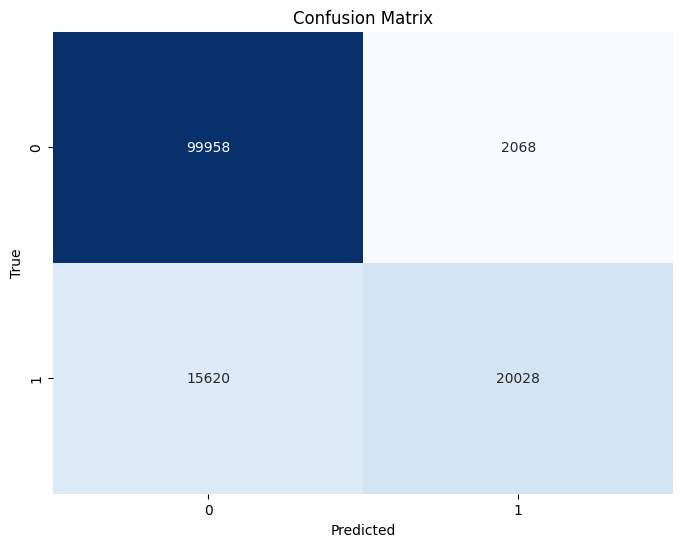

In [13]:
#plot confusion matrix to show the number of true positives, true negatives, false positives and false negatives
import matplotlib.pyplot as plt
import seaborn as sns

confusion_matrix = confusion_matrix(y_test['target'].values, y_test_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=['0', '1'], yticklabels=['0', '1'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

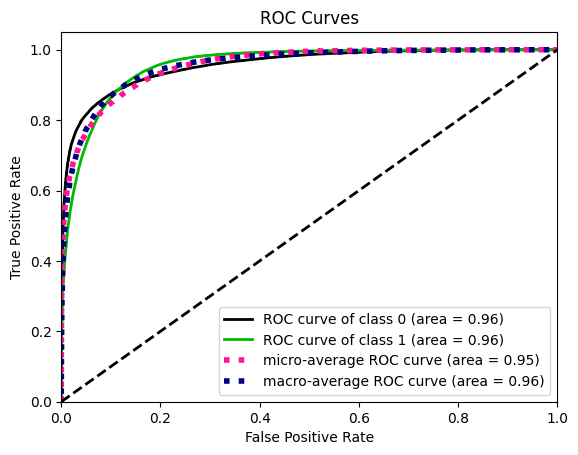

In [17]:
# use scikit plot to plot the ROC curve
import scikitplot as skplt

y_test_pred_proba = model.predict_proba(test_df.drop(columns=['customer_ID']))
skplt.metrics.plot_roc(y_test['target'].values, y_test_pred_proba)

plt.show()

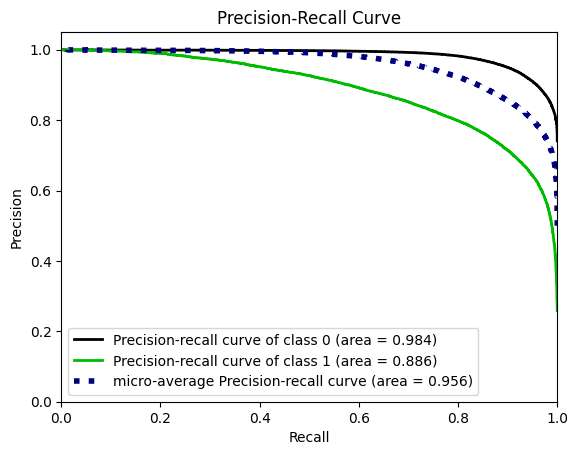

In [18]:
skplt.metrics.plot_precision_recall(y_test['target'].values, y_test_pred_proba)
plt.show()

<Axes: title={'center': 'KS Statistic Plot'}, xlabel='Threshold', ylabel='Percentage below threshold'>

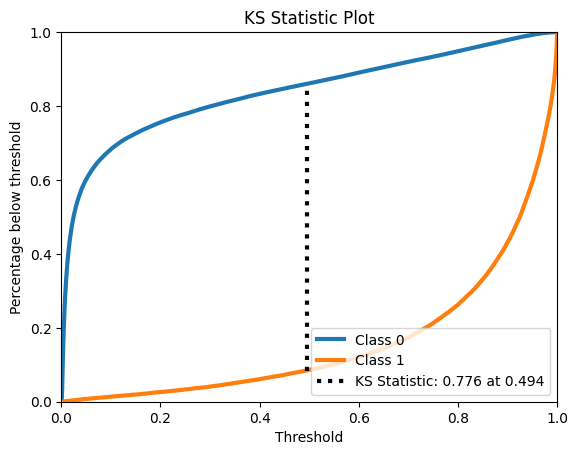

In [19]:
skplt.metrics.plot_ks_statistic(y_test['target'].values, y_test_pred_proba)

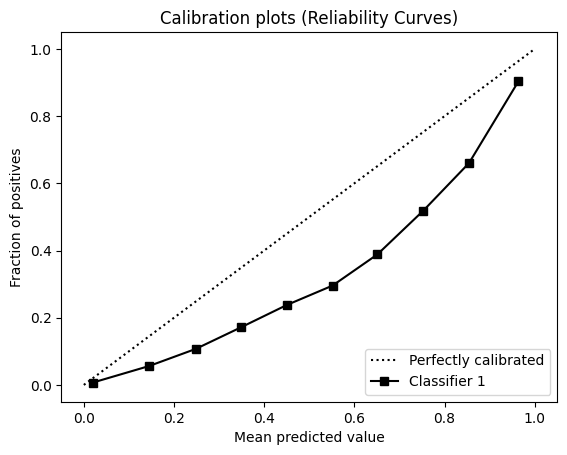

In [21]:
skplt.metrics.plot_calibration_curve(y_test['target'].values, [y_test_pred_proba])
plt.show()

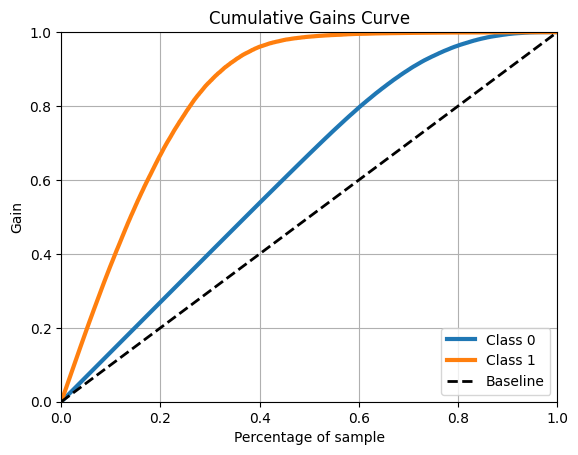

In [23]:
skplt.metrics.plot_cumulative_gain(y_test['target'].values, y_test_pred_proba)
plt.show()

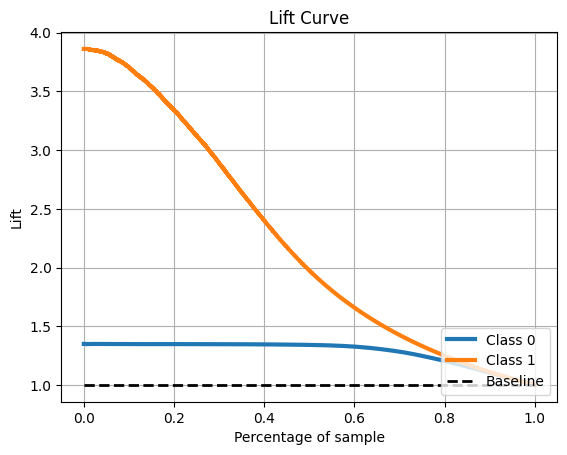

In [24]:
skplt.metrics.plot_lift_curve(y_test['target'].values, y_test_pred_proba)
plt.show()